2025-08-25 12:47:58.898782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 12:47:59.591338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-08-25 12:48:58.799773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-25 12:48:58.823164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

Epoch 1/300


2025-08-25 12:49:07.486817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2025-08-25 12:49:07.671517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-08-25 12:49:07.711727: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x70e42425be90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-25 12:49:07.711748: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-08-25 12:49:07.716772: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-25 12:49:07.820508: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

4640/4640 [==============================] - 30s 6ms/step - loss: 0.3006 - accuracy: 0.8792 - val_loss: 0.1744 - val_accuracy: 0.9341
Epoch 2/300
4640/4640 [==============================] - 25s 5ms/step - loss: 0.1227 - accuracy: 0.9518 - val_loss: 0.1259 - val_accuracy: 0.9552
Epoch 3/300
4640/4640 [==============================] - 25s 5ms/step - loss: 0.0779 - accuracy: 0.9720 - val_loss: 0.0792 - val_accuracy: 0.9737
Epoch 4/300
4640/4640 [==============================] - 25s 5ms/step - loss: 0.0513 - accuracy: 0.9827 - val_loss: 0.0754 - val_accuracy: 0.9789
Epoch 5/300
4640/4640 [==============================] - 26s 6ms/step - loss: 0.0411 - accuracy: 0.9872 - val_loss: 0.0952 - val_accuracy: 0.9711
Epoch 6/300
4640/4640 [==============================] - 25s 5ms/step - loss: 0.0400 - accuracy: 0.9890 - val_loss: 0.1600 - val_accuracy: 0.9625
Epoch 7/300
4640/4640 [==============================] - 25s 5ms/step - loss: 0.0304 - accuracy: 0.9912 - val_loss: 0.0942 - val_accurac

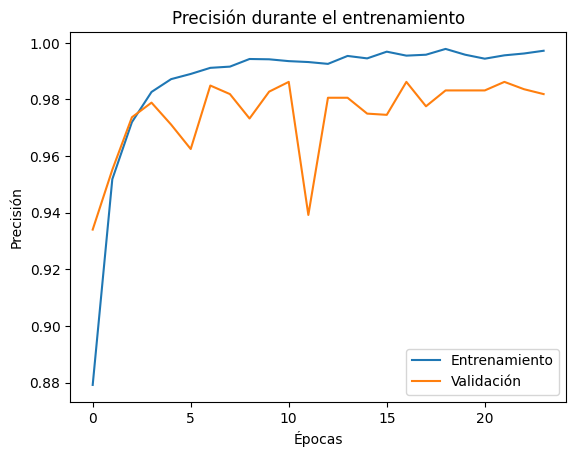

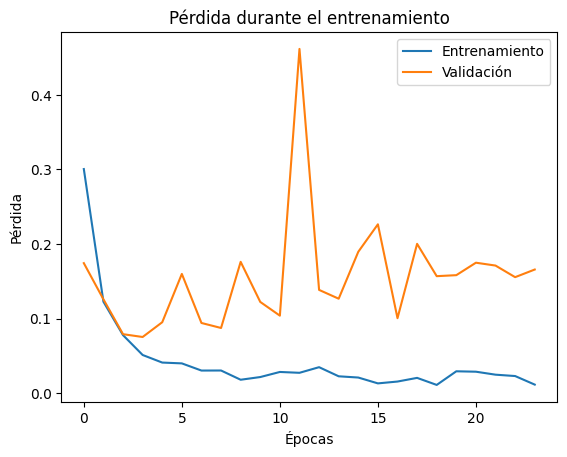

73/73 [==============================] - 3s 32ms/step


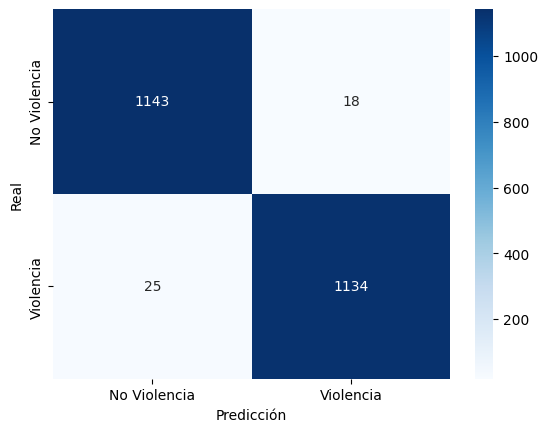

Modelo guardado como 'MobileNetV2'


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2  # <- CAMBIO: usar MobileNetV2

# Directorios de las imágenes
ruta_violentas = "../dataset/violencia"
ruta_no_violentas = "../dataset/no_violencia"

# Función para cargar las imágenes y sus etiquetas
def load_images_and_labels(ruta_violentas, ruta_no_violentas):
    imagenes = []
    etiquetas = []
    
    # Cargar imágenes de la carpeta de violencia
    for filename in os.listdir(ruta_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de la carpeta de no violencia
    for filename in os.listdir(ruta_no_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_no_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    # Convertir las listas a arrays de numpy
    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)
    
    # Normalizar las imágenes (escalarlas entre 0 y 1)
    imagenes = imagenes / 255.0
    
    return imagenes, etiquetas

# Crear el modelo MobileNetV2 preentrenado (solo este bloque cambia)
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # <- CAMBIO
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)  # Para clasificación con 2 clases
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False  # Congelar las capas base para preentrenar

    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Función de entrenamiento
def train_model(model, X_train, y_train, X_val, y_val, epochs=300, batch_size=2):
    model_history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=[ 
            tf.keras.callbacks.EarlyStopping(patience=20),
            tf.keras.callbacks.ModelCheckpoint('modelo_mejorado_MobileNetV2.h5', save_best_only=True),
            tf.keras.callbacks.TensorBoard(log_dir='./logs')  # Para seguimiento con TensorBoard
        ]
    )
    return model_history

# Visualización de los resultados de entrenamiento
def plot_training_history(model_history):
    # Graficar precisión
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

    # Graficar pérdida
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

# Matriz de confusión
def plot_confusion_matrix(model, X_val, y_val):
    preds = model.predict(X_val)
    predicted_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_val, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Violencia', 'Violencia'], yticklabels=['No Violencia', 'Violencia'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Cargar las imágenes y etiquetas
imagenes, etiquetas = load_images_and_labels(ruta_violentas, ruta_no_violentas)

# Dividir en conjunto de entrenamiento y validación (80% - 20%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=2)

# Crear el modelo preentrenado
model = create_model()

# Entrenar el modelo
model_history = train_model(model, X_train, y_train, X_val, y_val)

# Graficar los resultados de entrenamiento y validación
plot_training_history(model_history)

# Graficar la matriz de confusión del conjunto de validación
plot_confusion_matrix(model, X_val, y_val)

# Guardar el modelo entrenado
model.save('Modelo_MobileNetV2.h5')  # (dejé el nombre exactamente igual como pediste)
print("Modelo guardado como 'MobileNetV2'")


2025-08-25 12:59:53.093619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 12:59:53.709168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-08-25 13:00:15.555609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-25 13:00:15.580168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

  6/138 [>.............................] - ETA: 3s

2025-08-25 13:00:20.657037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


138/138 [==============================] - 5s 32ms/step
Matriz de Confusión:
[[2171   29]
 [  57 2143]]


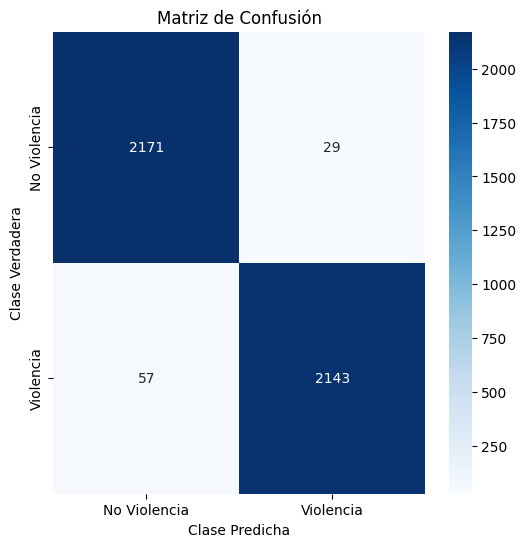

Precisión: 0.99
Recall: 0.97
F1-Score: 0.98


In [1]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Directorios de las imágenes de prueba
ruta_test_violencia = "../test2/violencia"
ruta_test_no_violencia = "../test2/no_violencia"

# Función para cargar las imágenes y etiquetas de prueba
def cargar_datos_test(ruta_violencia, ruta_no_violencia):
    imagenes = []
    etiquetas = []

    # Cargar imágenes de violencia
    for filename in os.listdir(ruta_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_violencia, filename), target_size=(224, 224))
            imagen = img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de no violencia
    for filename in os.listdir(ruta_no_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_no_violencia, filename), target_size=(224, 224))
            imagen = img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)

    return imagenes, etiquetas

# Cargar datos de prueba
X_test, y_test = cargar_datos_test(ruta_test_violencia, ruta_test_no_violencia)

# Cargar el modelo preentrenado (asegúrate de tener el archivo .h5 del modelo final)
modelo_cargado = load_model("Modelo_MobileNetV2.h5")

# Normalizar las imágenes de prueba
X_test = X_test / 255.0  # Normalizar las imágenes de prueba

# Realizar predicciones con el modelo cargado
predicciones = modelo_cargado.predict(X_test)

# Convertir las predicciones a las clases (1 para violencia, 0 para no violencia)
predicciones_clase = np.argmax(predicciones, axis=1)
y_test_clase = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_test_clase, predicciones_clase)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(matriz_confusion)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["No Violencia", "Violencia"], yticklabels=["No Violencia", "Violencia"])
plt.title("Matriz de Confusión")
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

# Calcular precisión, recall, f1-score (opcional)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_clase, predicciones_clase)
recall = recall_score(y_test_clase, predicciones_clase)
f1 = f1_score(y_test_clase, predicciones_clase)

print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")